Description code for IMU here!

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, firwin, filtfilt
import sys
import os
import csv
import ezc3d
import imufusion

In [2]:
def load_c3d_file(c3d_path):
    c3d = ezc3d.c3d(c3d_path)
    
    # Point data
    point_data = c3d['data']['points']
    point_labels = [label.rstrip() for label in c3d['parameters']['POINT']['LABELS']['value']]
    point_units = ["mm"] * len(point_labels)  # Typically, point data are in millimeters
    point_frame_rate = c3d['parameters']['POINT']['RATE']['value'][0]

    # Analog data
    analog_data = c3d['data']['analogs']
    analog_labels = [label.rstrip() for label in c3d['parameters']['ANALOG']['LABELS']['value']]
    analog_units = c3d['parameters']['ANALOG']['UNITS']['value']  # Get units for analog data
    analog_frame_rate = c3d['parameters']['ANALOG']['RATE']['value'][0]

    return point_data, point_labels, point_units, point_frame_rate, analog_data, analog_labels, analog_units, analog_frame_rate

pc001_path = '../data/vicon_plugin_gait/PC001_sts01_sts1.c3d'
pc002_path = '../data/vicon_plugin_gait/PC002_sts01_sts1.c3d'
td001_path = '../data/vicon_plugin_gait/TD001_STS01_sts1.c3d'
td002_path = '../data/vicon_plugin_gait/TD002_STS01_sts1.c3d'

# Load the data for PC001
point_data_pc001, point_labels_pc001, point_units_pc001, point_frame_rate_pc001, analog_data_pc001, analog_labels_pc001, analog_units_pc001, analog_frame_rate_pc001 = load_c3d_file(pc001_path)

# Load the data for PC002
point_data_pc002, point_labels_pc002, point_units_pc002, point_frame_rate_pc002, analog_data_pc002, analog_labels_pc002, analog_units_pc002, analog_frame_rate_pc002 = load_c3d_file(pc002_path)

# Load the data for TD001
point_data_td001, point_labels_td001, point_units_td001, point_frame_rate_td001, analog_data_td001, analog_labels_td001, analog_units_td001, analog_frame_rate_td001 = load_c3d_file(td001_path)

# Load the data for TD002
point_data_td002, point_labels_td002, point_units_td002, point_frame_rate_td002, analog_data_td002, analog_labels_td002, analog_units_td002, analog_frame_rate_td002 = load_c3d_file(td002_path)

In [3]:
# Function to display column labels along with their indexes side by side
def display_labels_with_indexes(labels, num_columns=1):
    # Separate the labels into rows of the specified number of columns
    rows = [labels[i:i + num_columns] for i in range(0, len(labels), num_columns)]
    index_rows = [range(i, min(i + num_columns, len(labels))) for i in range(0, len(labels), num_columns)]

    # Print the labels and indexes side by side
    for index_row, row in zip(index_rows, rows):
        row_display = "  ".join(f'{idx}: {label}' for idx, label in zip(index_row, row))
        print(row_display)

## Example usage for PC001 analog labels
print("PC001 Analog Labels:")
#display_labels_with_indexes(analog_labels_pc001)

## Example usage for PC002 analog labels
print("\nPC002 Analog Labels:")
#display_labels_with_indexes(analog_labels_pc002)

## Example usage for TD001 analog labels
print("\nTD001 Analog Labels:")
#display_labels_with_indexes(analog_labels_td001)

## Example usage for TD002 analog labels
print("\nTD002 Analog Labels:")
#display_labels_with_indexes(analog_labels_td002)

PC001 Analog Labels:

PC002 Analog Labels:

TD001 Analog Labels:

TD002 Analog Labels:


In [4]:
## Coord Columns Delsys Sensor 1 - accelerometer and gyroscope
pc001_acc_sensor1 = [112, 114, 113]
pc001_gyro_sensor1 = [115, 117, 116]
## Coord Columns Delsys Sensor 2 - accelerometer and gyroscope
pc001_acc_sensor2 = [121, 123, 122]
pc001_gyro_sensor2 = [124, 126, 125]

## Coord Columns Delsys Sensor 1 - accelerometer and gyroscope
pc002_acc_sensor1 = [121, 123, 122]
pc002_gyro_sensor1 = [115, 117, 116]
## Coord Columns Delsys Sensor 2 - accelerometer and gyroscope
pc002_acc_sensor2 = [121, 123, 122]
pc002_gyro_sensor2 = [124, 126, 125]


## Coord Columns Delsys Sensor 1 - accelerometer and gyroscope
td001_acc_sensor1 = [128, 130, 129]
td001_gyro_sensor1 = [131, 133, 132]
## Coord Columns Delsys Sensor 2 - accelerometer and gyroscope
td001_acc_sensor2 = [137, 139, 138]
td001_gyro_sensor2 = [140, 142, 141]

## Coord Columns Delsys Sensor 1 - accelerometer and gyroscope
td002_acc_sensor1 = [128, 130, 129]
td002_gyro_sensor1 = [131, 133, 132]
## Coord Columns Delsys Sensor 2 - accelerometer and gyroscope
td002_acc_sensor2 = [137, 139, 138]
td002_gyro_sensor2 = [140, 142, 141]

In [5]:
def apply_filter(data, sample_rate, method='butterworth', cutoff=5, order=4, numtaps=255, padlen=128):
    """Apply a specified filter to the data with padding."""
    nyquist = 0.5 * sample_rate
    normal_cutoff = cutoff / nyquist
    
    if method == 'butterworth':
        b, a = butter(order, normal_cutoff, btype='low', analog=False)
        padded_data = np.pad(data, ((padlen, padlen), (0, 0)), mode='reflect')
        filtered_data = filtfilt(b, a, padded_data, axis=0)
        filtered_data = filtered_data[padlen:-padlen, :]
    
    elif method == 'fir':
        fir_coeff = firwin(numtaps, normal_cutoff, window='blackman')
        padded_data = np.pad(data, ((padlen, padlen), (0, 0)), mode='reflect')
        filtered_data = filtfilt(fir_coeff, 1.0, padded_data, axis=0)
        filtered_data = filtered_data[padlen:-padlen, :]
    
    else:
        raise ValueError("Method must be 'butterworth' or 'fir'")
    
    return filtered_data


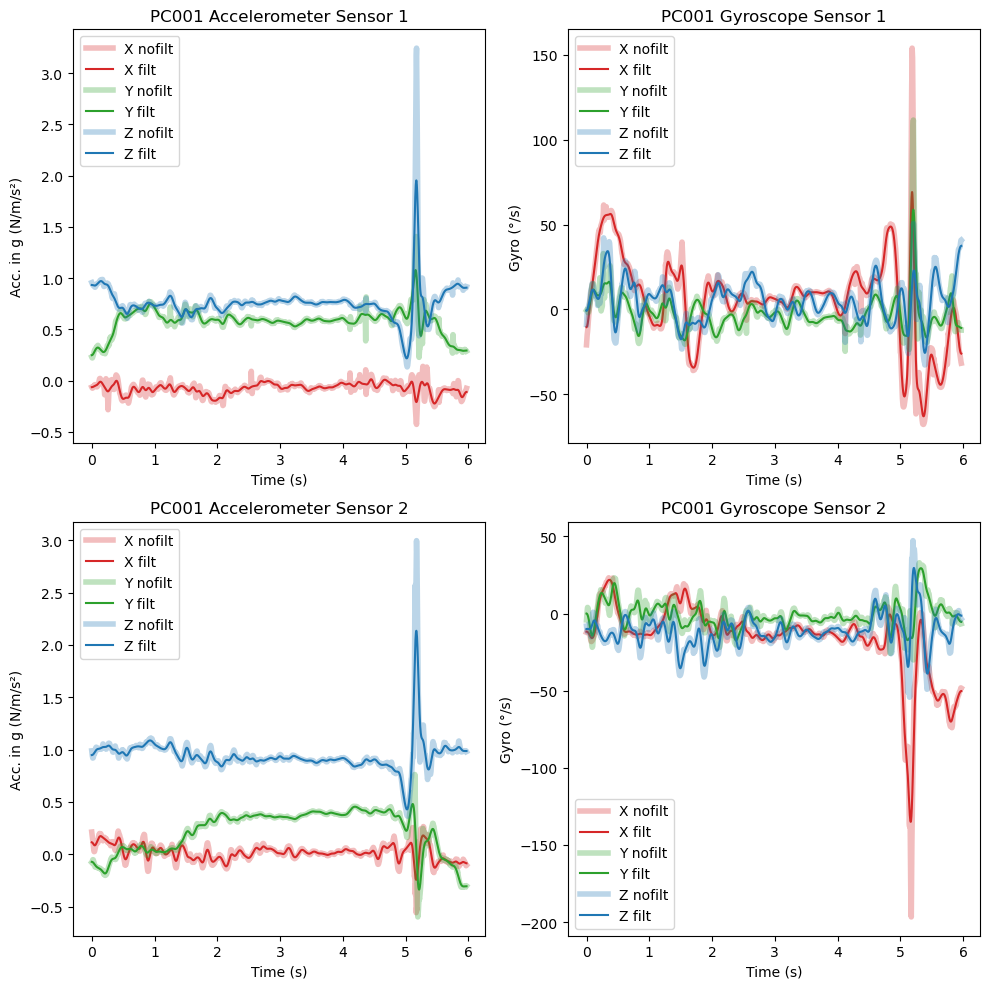

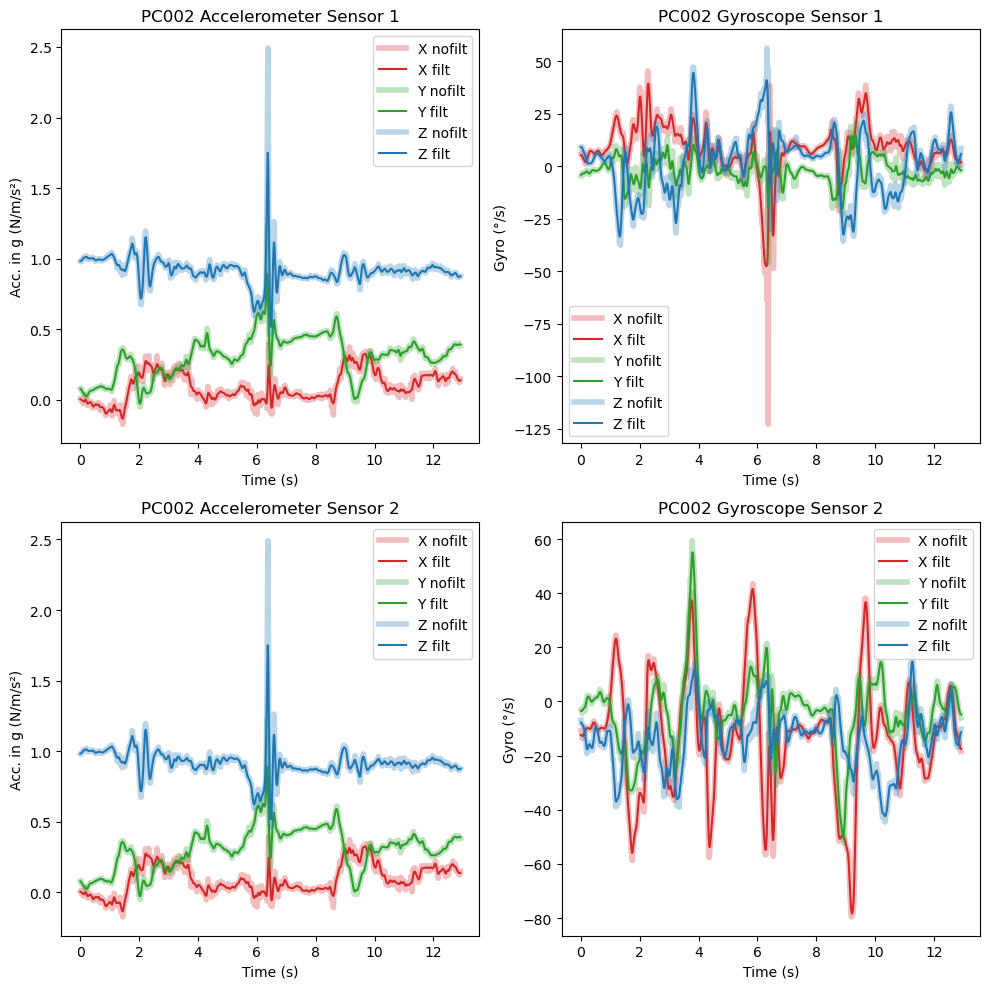

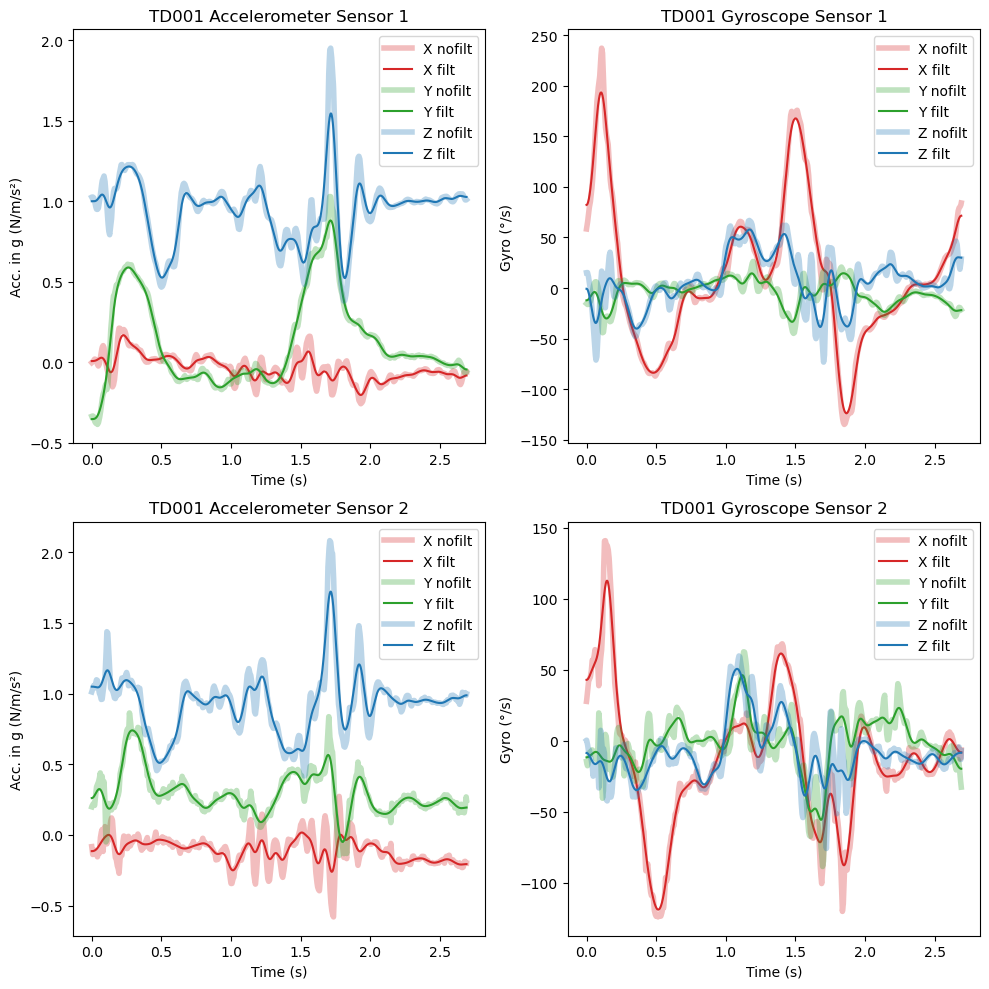

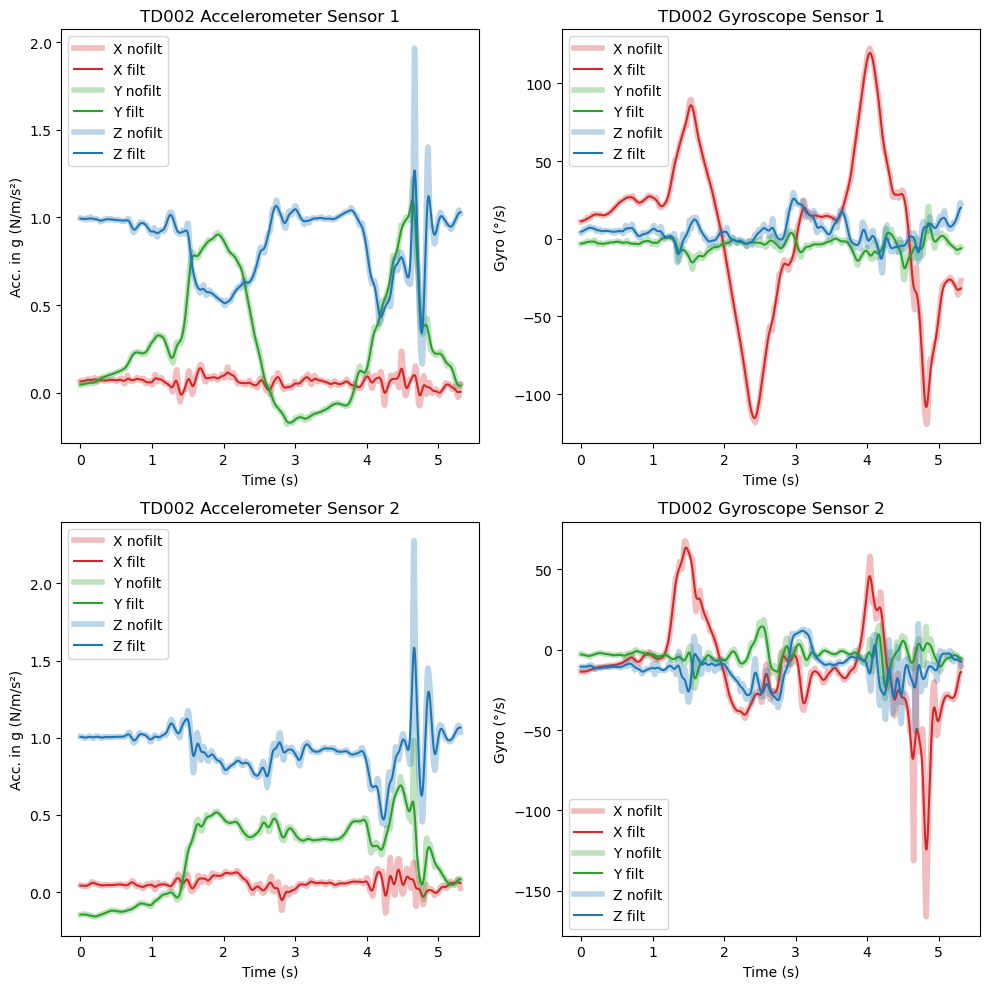

In [6]:
def process_and_plot_data(analog_data, acc_sensor1, gyro_sensor1, acc_sensor2, gyro_sensor2, analog_frame_rate, title_prefix=''):
    # Define constants
    gravity = 9.81  # Acceleration due to gravity in m/s²
    sample_rate = analog_frame_rate

    # Extract Delsys Sensor 1 - accelerometer and gyroscope data
    accelerometer_nofilt_1 = analog_data[:, acc_sensor1].T.reshape(-1, 3)
    gyroscope_nofilt_1 = analog_data[:, gyro_sensor1].T.reshape(-1, 3)

    # Adjust and convert Sensor 1 data
    accelerometer_nofilt_1 = (accelerometer_nofilt_1 * np.array([1, 1, -1])) / gravity
    gyroscope_nofilt_1 = (gyroscope_nofilt_1 * np.array([1, 1, -1])) * (180 / np.pi)

    # Extract Delsys Sensor 2 - accelerometer and gyroscope data
    accelerometer_nofilt_2 = analog_data[:, acc_sensor2].T.reshape(-1, 3)
    gyroscope_nofilt_2 = analog_data[:, gyro_sensor2].T.reshape(-1, 3)

    # Adjust and convert Sensor 2 data
    accelerometer_nofilt_2 = (accelerometer_nofilt_2 * np.array([1, 1, -1])) / gravity
    gyroscope_nofilt_2 = (gyroscope_nofilt_2 * np.array([1, 1, -1])) * (180 / np.pi)

    # Apply the chosen filter to accelerometer and gyroscope data ('butterworth' or 'fir')
    filter_method = 'fir'
    accelerometer_1 = apply_filter(accelerometer_nofilt_1, sample_rate, method=filter_method)
    gyroscope_1 = apply_filter(gyroscope_nofilt_1, sample_rate, method=filter_method)
    accelerometer_2 = apply_filter(accelerometer_nofilt_2, sample_rate, method=filter_method)
    gyroscope_2 = apply_filter(gyroscope_nofilt_2, sample_rate, method=filter_method)

    # Create a time vector for the x-axis based on the sampling rate
    time = np.linspace(0, len(accelerometer_1) / analog_frame_rate, len(accelerometer_1))

    # Create subplots with a smaller figure size
    fig, axs = plt.subplots(2, 2, figsize=(10, 10))

    # Plot accelerometer data for Sensor 1 (top left)
    axs[0, 0].plot(time, accelerometer_nofilt_1[:, 0], "tab:red", label="X nofilt", linewidth=4, alpha=0.3)
    axs[0, 0].plot(time, accelerometer_1[:, 0], "tab:red", label="X filt")
    axs[0, 0].plot(time, accelerometer_nofilt_1[:, 1], "tab:green", label="Y nofilt", linewidth=4, alpha=0.3)
    axs[0, 0].plot(time, accelerometer_1[:, 1], "tab:green", label="Y filt")
    axs[0, 0].plot(time, accelerometer_nofilt_1[:, 2], "tab:blue", label="Z nofilt", linewidth=4, alpha=0.3)
    axs[0, 0].plot(time, accelerometer_1[:, 2], "tab:blue", label="Z filt")
    axs[0, 0].set_title(f'{title_prefix} Accelerometer Sensor 1')
    axs[0, 0].set_xlabel('Time (s)')
    axs[0, 0].set_ylabel('Acc. in g (N/m/s²)')
    axs[0, 0].legend()

    # Plot accelerometer data for Sensor 2 (bottom left)
    axs[1, 0].plot(time, accelerometer_nofilt_2[:, 0], "tab:red", label="X nofilt", linewidth=4, alpha=0.3)
    axs[1, 0].plot(time, accelerometer_2[:, 0], "tab:red", label="X filt")
    axs[1, 0].plot(time, accelerometer_nofilt_2[:, 1], "tab:green", label="Y nofilt", linewidth=4, alpha=0.3)
    axs[1, 0].plot(time, accelerometer_2[:, 1], "tab:green", label="Y filt")
    axs[1, 0].plot(time, accelerometer_nofilt_2[:, 2], "tab:blue", label="Z nofilt", linewidth=4, alpha=0.3)
    axs[1, 0].plot(time, accelerometer_2[:, 2], "tab:blue", label="Z filt")
    axs[1, 0].set_title(f'{title_prefix} Accelerometer Sensor 2')
    axs[1, 0].set_xlabel('Time (s)')
    axs[1, 0].set_ylabel('Acc. in g (N/m/s²)')
    axs[1, 0].legend()

    # Plot gyroscope data for Sensor 1 (top right)
    axs[0, 1].plot(time, gyroscope_nofilt_1[:, 0], "tab:red", label="X nofilt", linewidth=4, alpha=0.3)
    axs[0, 1].plot(time, gyroscope_1[:, 0], "tab:red", label="X filt")
    axs[0, 1].plot(time, gyroscope_nofilt_1[:, 1], "tab:green", label="Y nofilt", linewidth=4, alpha=0.3)
    axs[0, 1].plot(time, gyroscope_1[:, 1], "tab:green", label="Y filt")
    axs[0, 1].plot(time, gyroscope_nofilt_1[:, 2], "tab:blue", label="Z nofilt", linewidth=4, alpha=0.3)
    axs[0, 1].plot(time, gyroscope_1[:, 2], "tab:blue", label="Z filt")
    axs[0, 1].set_title(f'{title_prefix} Gyroscope Sensor 1')
    axs[0, 1].set_xlabel('Time (s)')
    axs[0, 1].set_ylabel('Gyro (°/s)')
    axs[0, 1].legend()

    # Plot gyroscope data for Sensor 2 (bottom right)
    axs[1, 1].plot(time, gyroscope_nofilt_2[:, 0], "tab:red", label="X nofilt", linewidth=4, alpha=0.3)
    axs[1, 1].plot(time, gyroscope_2[:, 0], "tab:red", label="X filt")
    axs[1, 1].plot(time, gyroscope_nofilt_2[:, 1], "tab:green", label="Y nofilt", linewidth=4, alpha=0.3)
    axs[1, 1].plot(time, gyroscope_2[:, 1], "tab:green", label="Y filt")
    axs[1, 1].plot(time, gyroscope_nofilt_2[:, 2], "tab:blue", label="Z nofilt", linewidth=4, alpha=0.3)
    axs[1, 1].plot(time, gyroscope_2[:, 2], "tab:blue", label="Z filt")
    axs[1, 1].set_title(f'{title_prefix} Gyroscope Sensor 2')
    axs[1, 1].set_xlabel('Time (s)')
    axs[1, 1].set_ylabel('Gyro (°/s)')
    axs[1, 1].legend()

    # Adjust layout
    plt.tight_layout()
    plt.show()

# Example usage for PC001
process_and_plot_data(analog_data_pc001, pc001_acc_sensor1, pc001_gyro_sensor1, pc001_acc_sensor2, pc001_gyro_sensor2, analog_frame_rate_pc001, title_prefix='PC001')

# Example usage for PC002
process_and_plot_data(analog_data_pc002, pc002_acc_sensor1, pc002_gyro_sensor1, pc002_acc_sensor2, pc002_gyro_sensor2, analog_frame_rate_pc002, title_prefix='PC002')

# Example usage for TD001
process_and_plot_data(analog_data_td001, td001_acc_sensor1, td001_gyro_sensor1, td001_acc_sensor2, td001_gyro_sensor2, analog_frame_rate_td001, title_prefix='TD001')

# Example usage for TD002
process_and_plot_data(analog_data_td002, td002_acc_sensor1, td002_gyro_sensor1, td002_acc_sensor2, td002_gyro_sensor2, analog_frame_rate_td002, title_prefix='TD002')

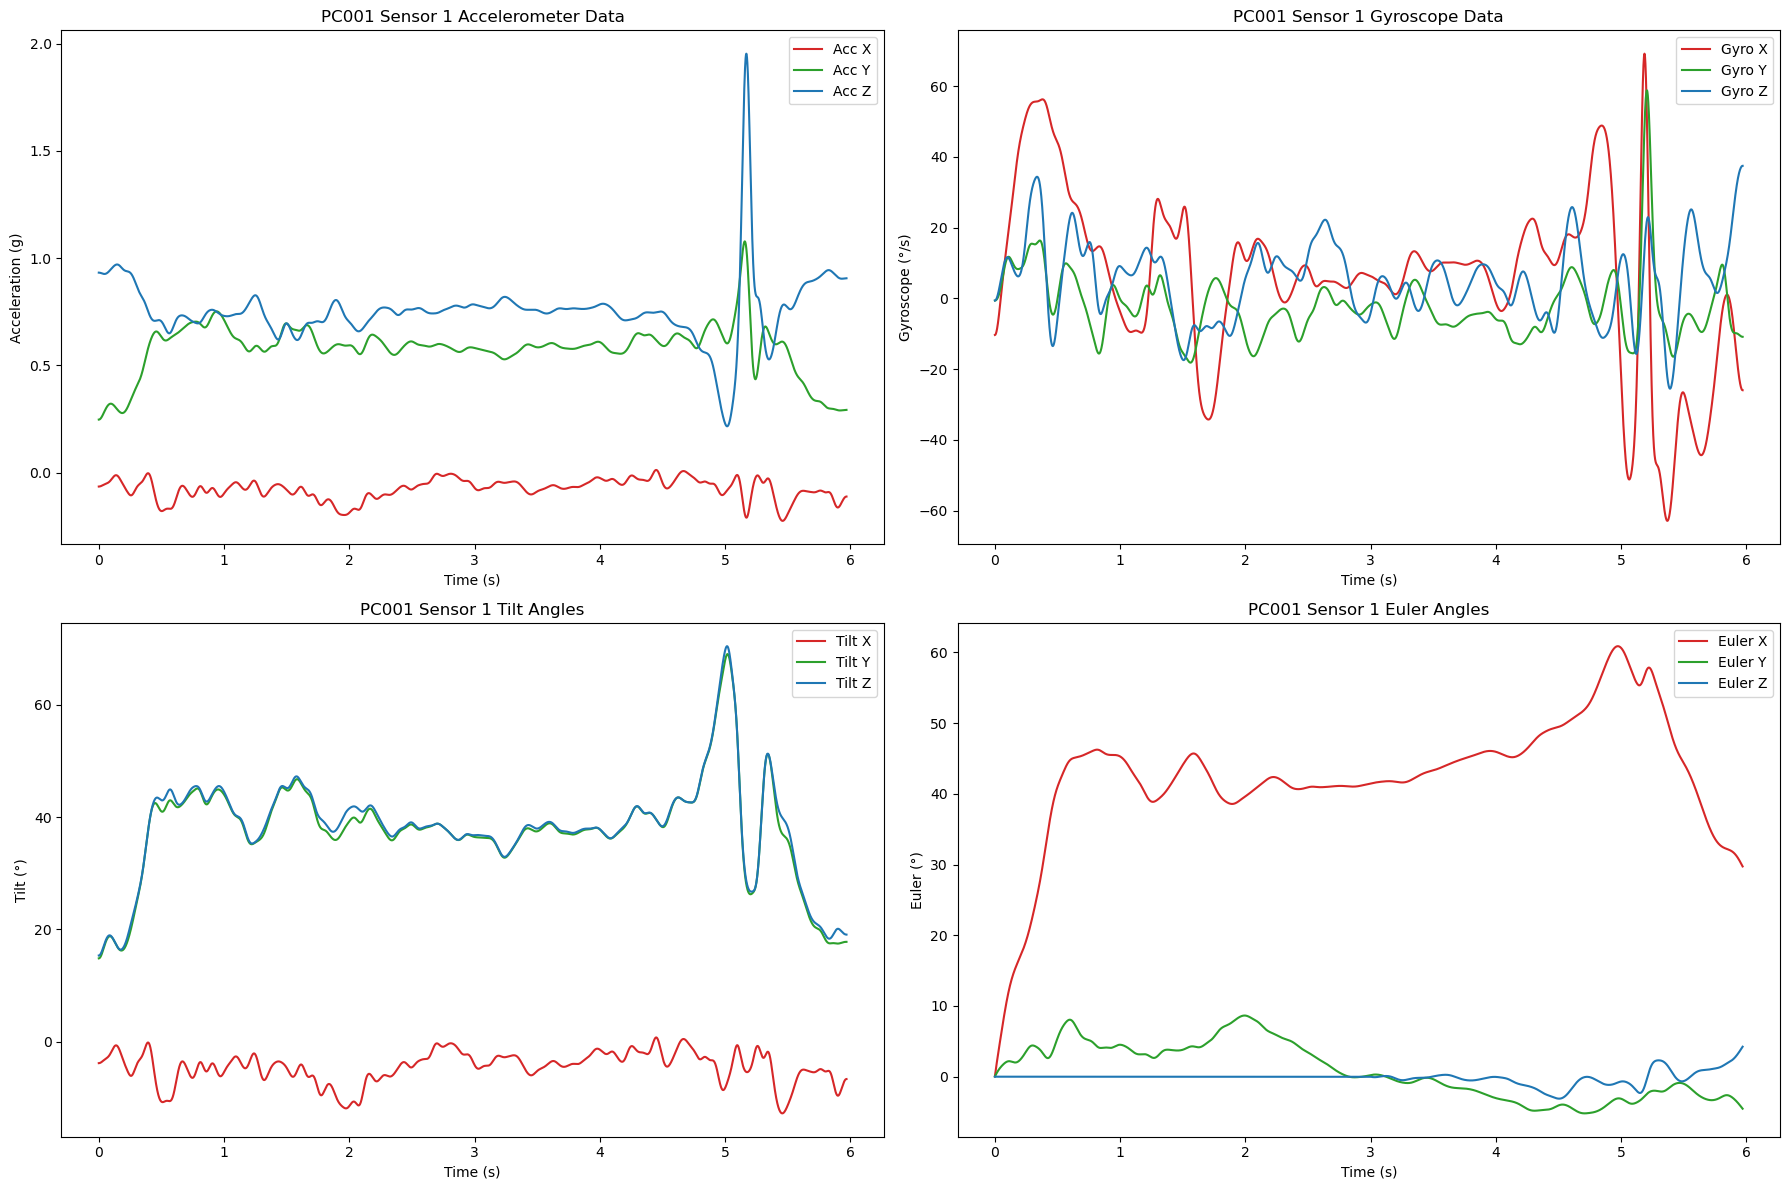

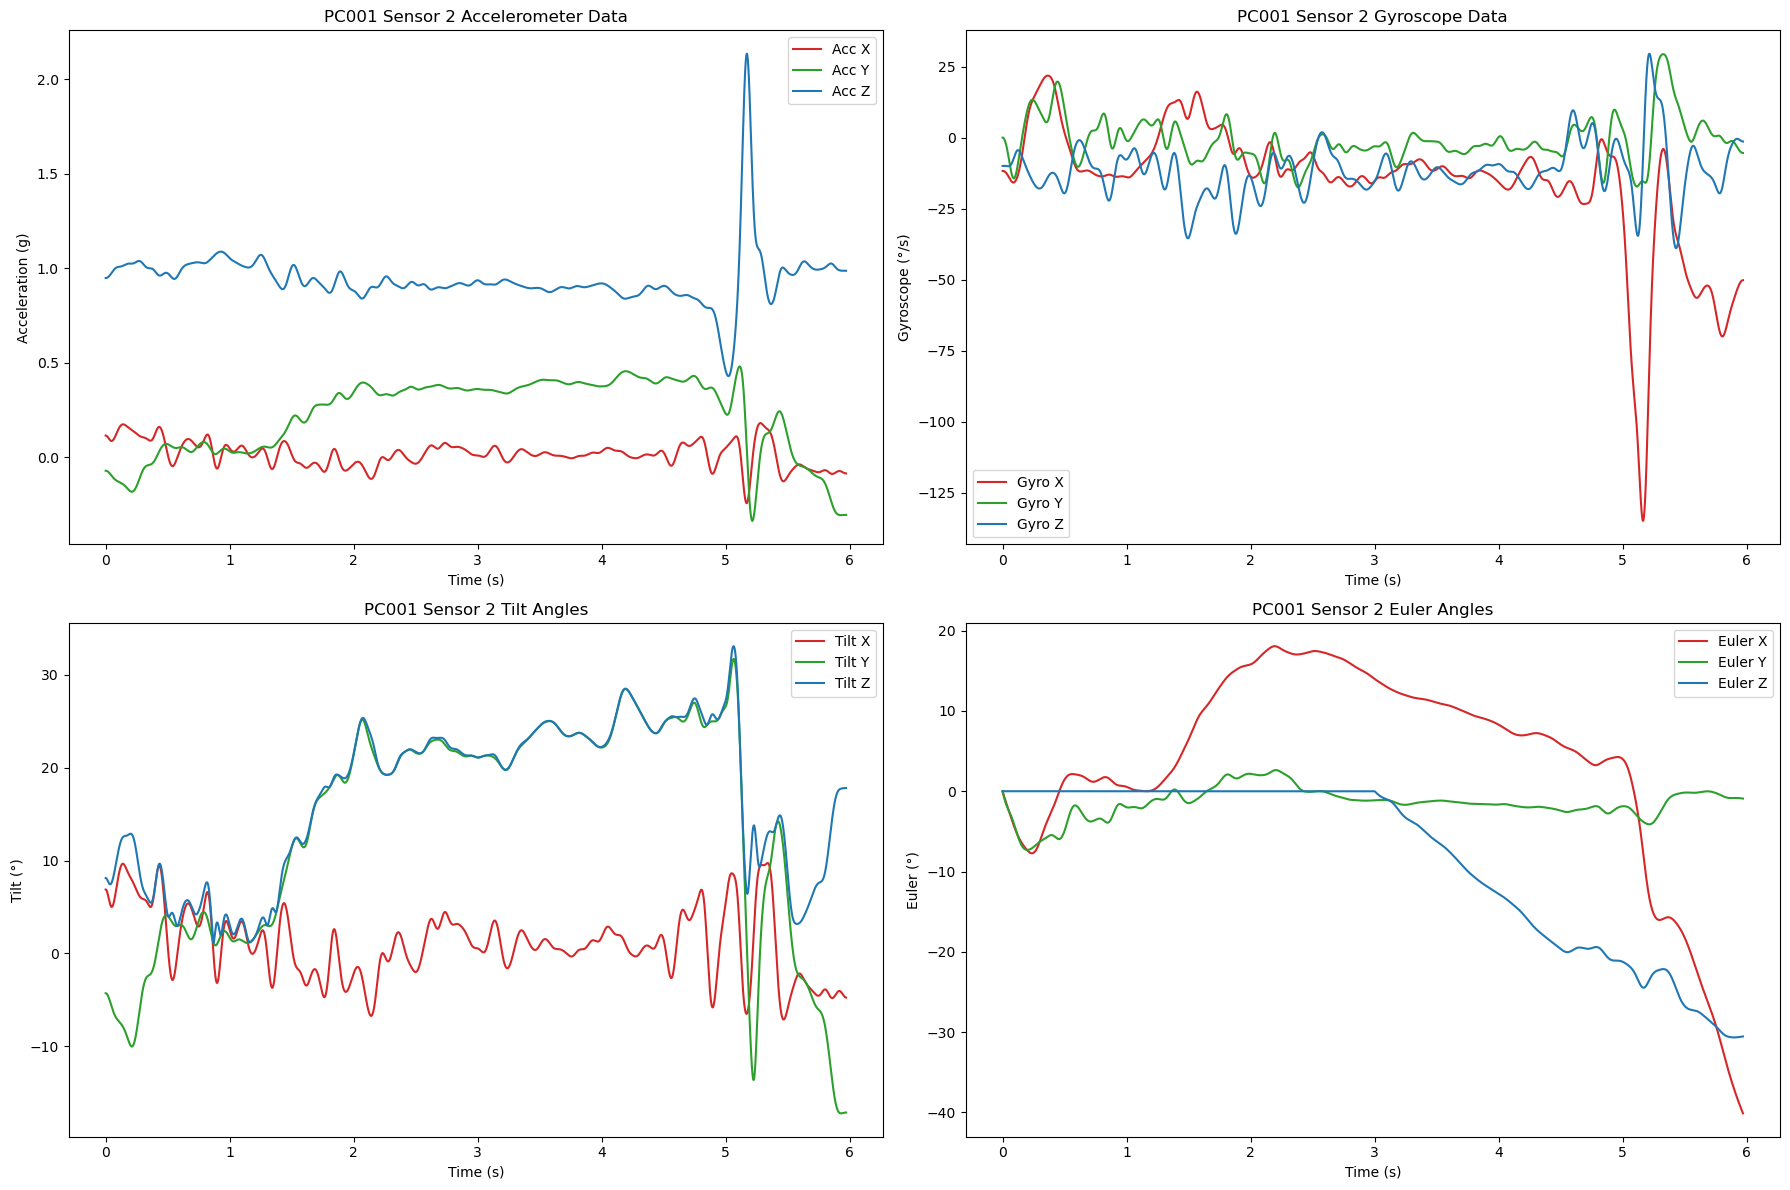

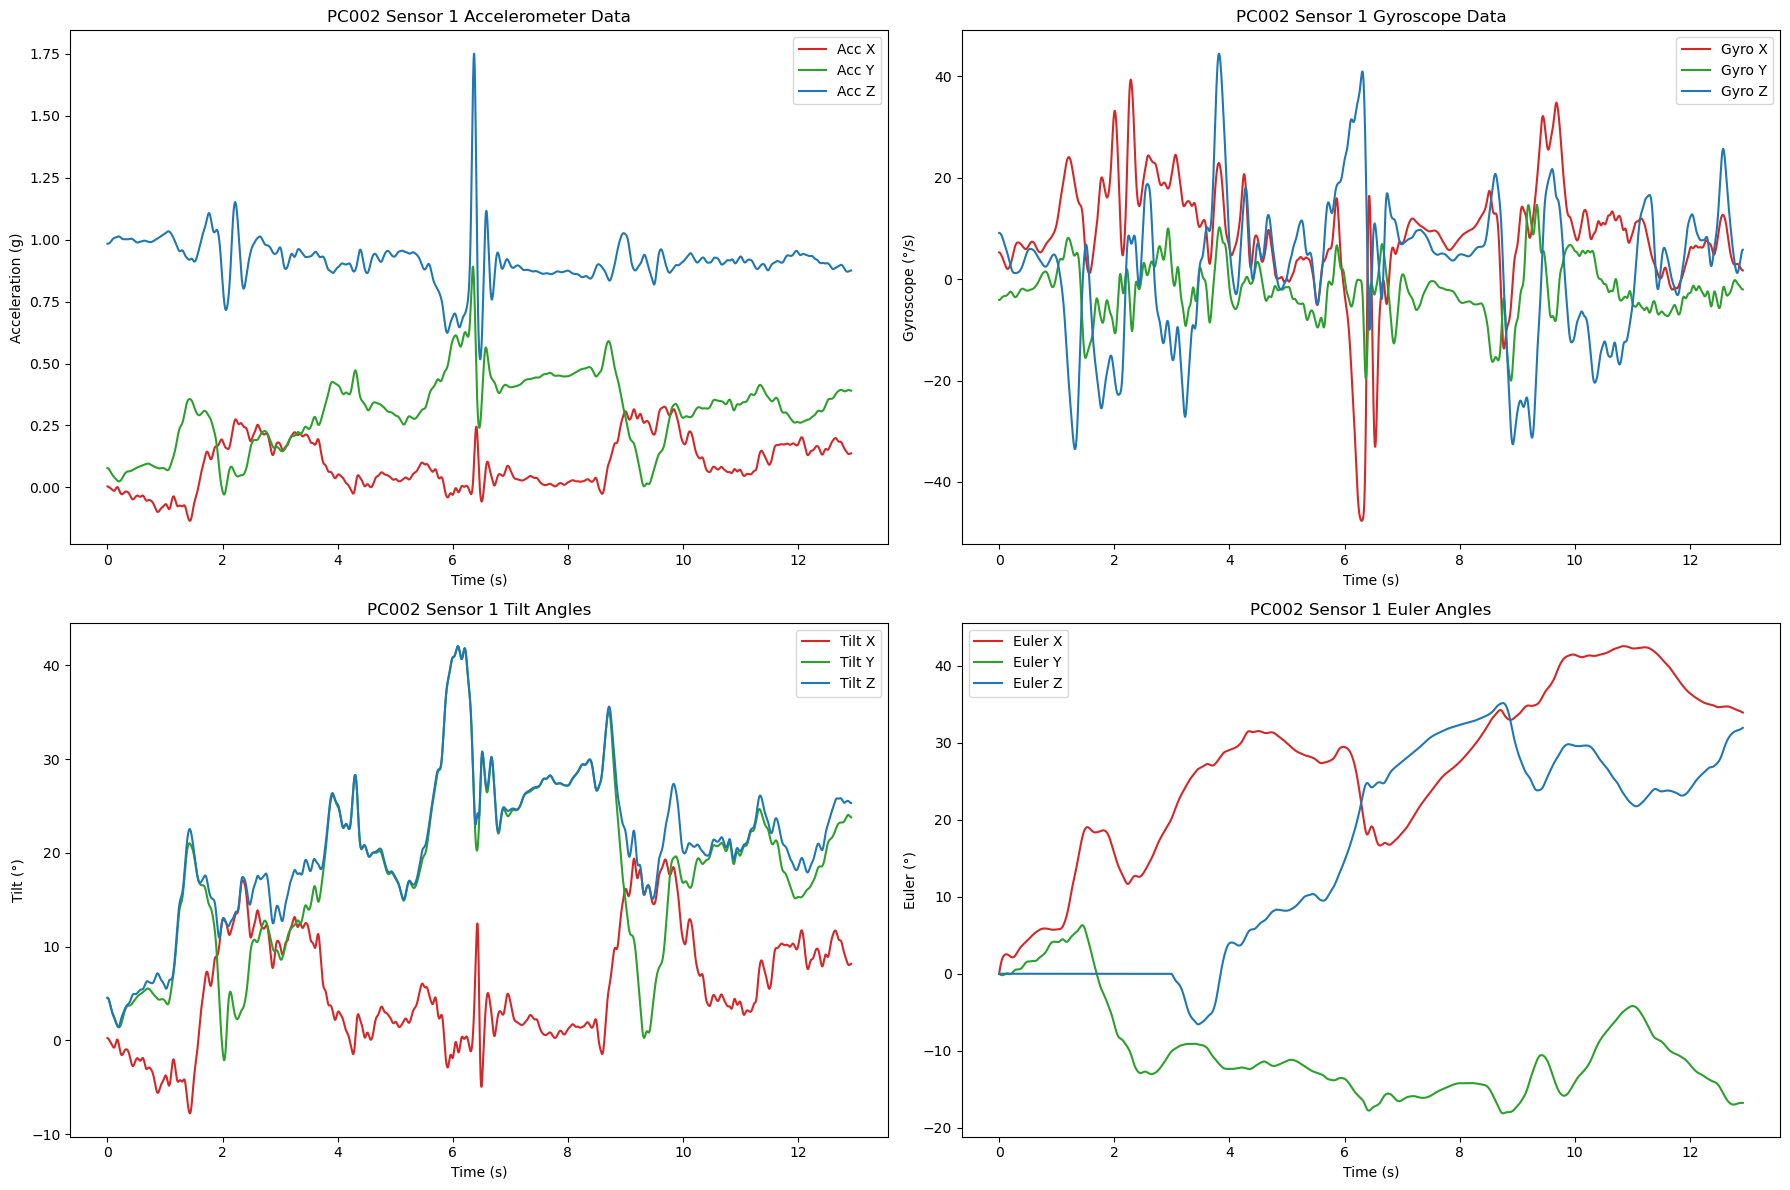

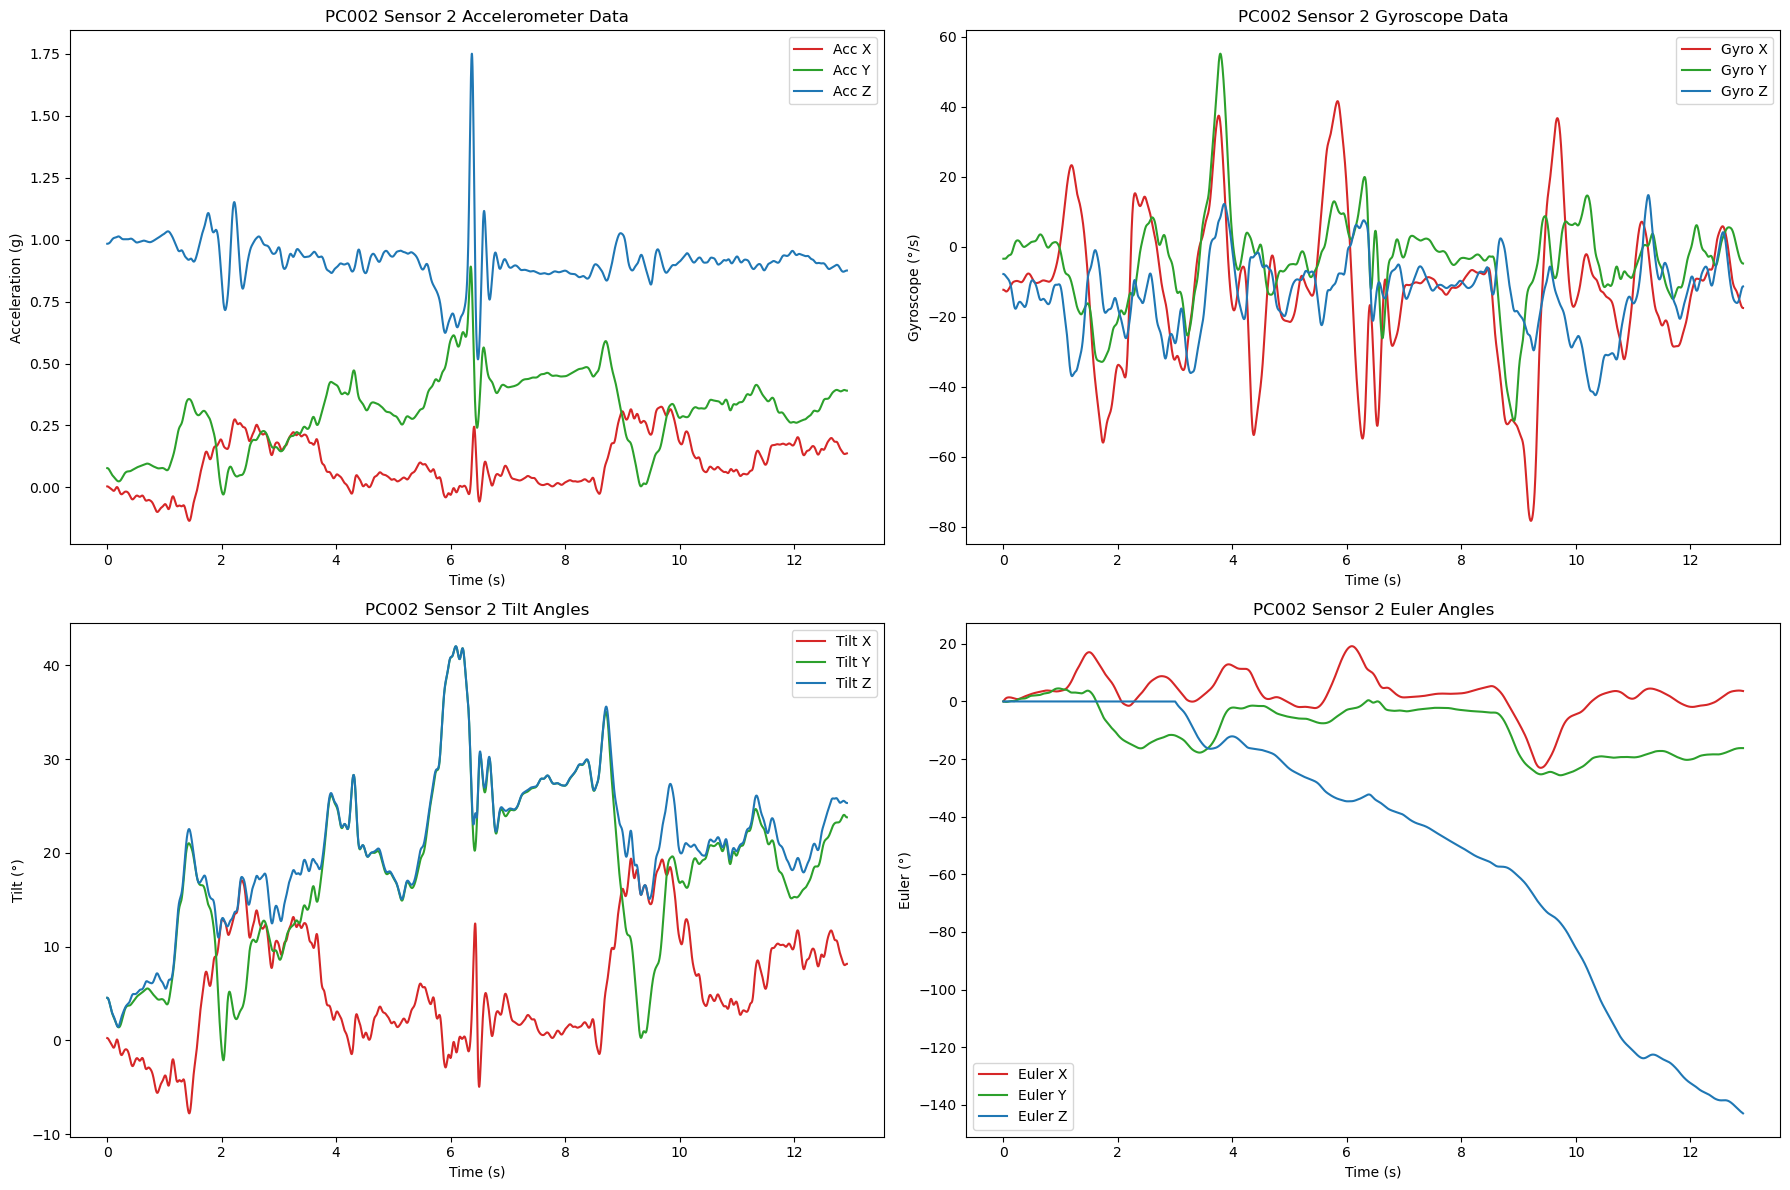

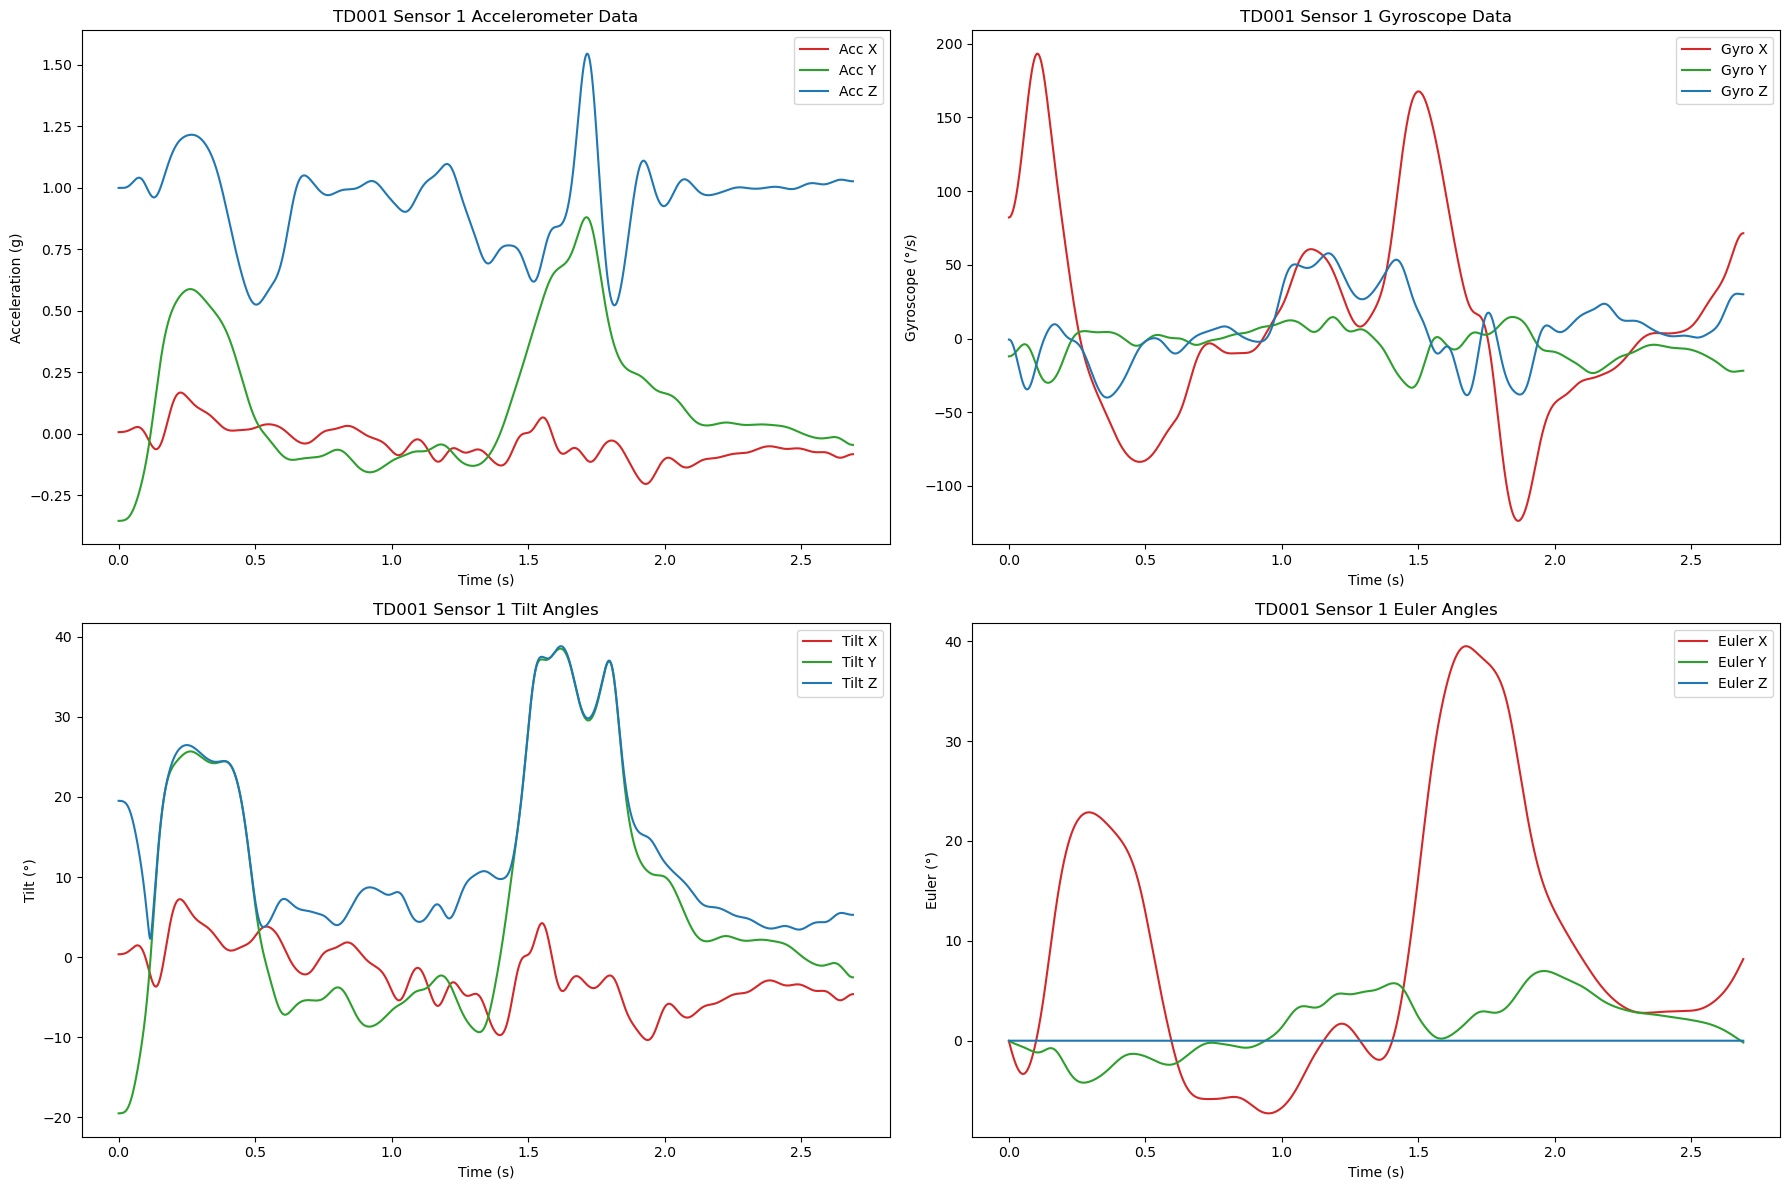

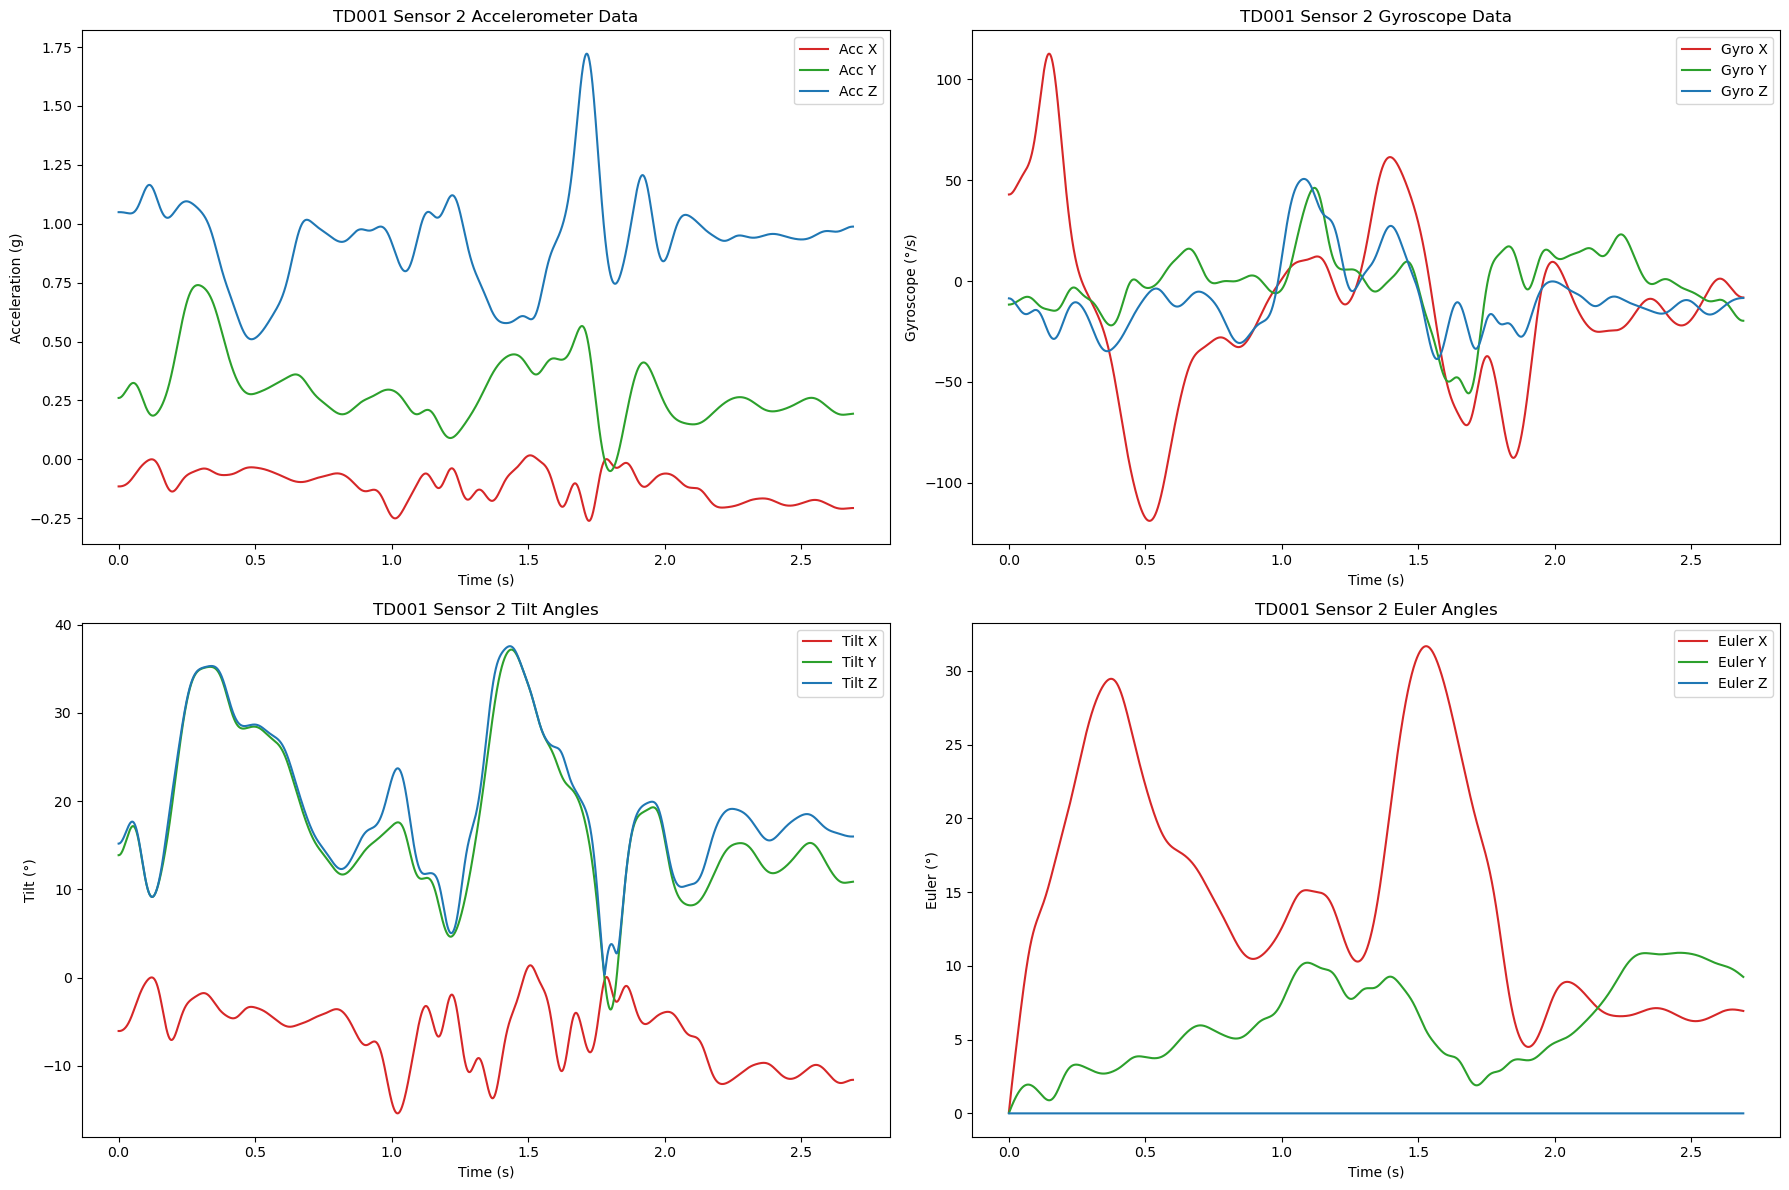

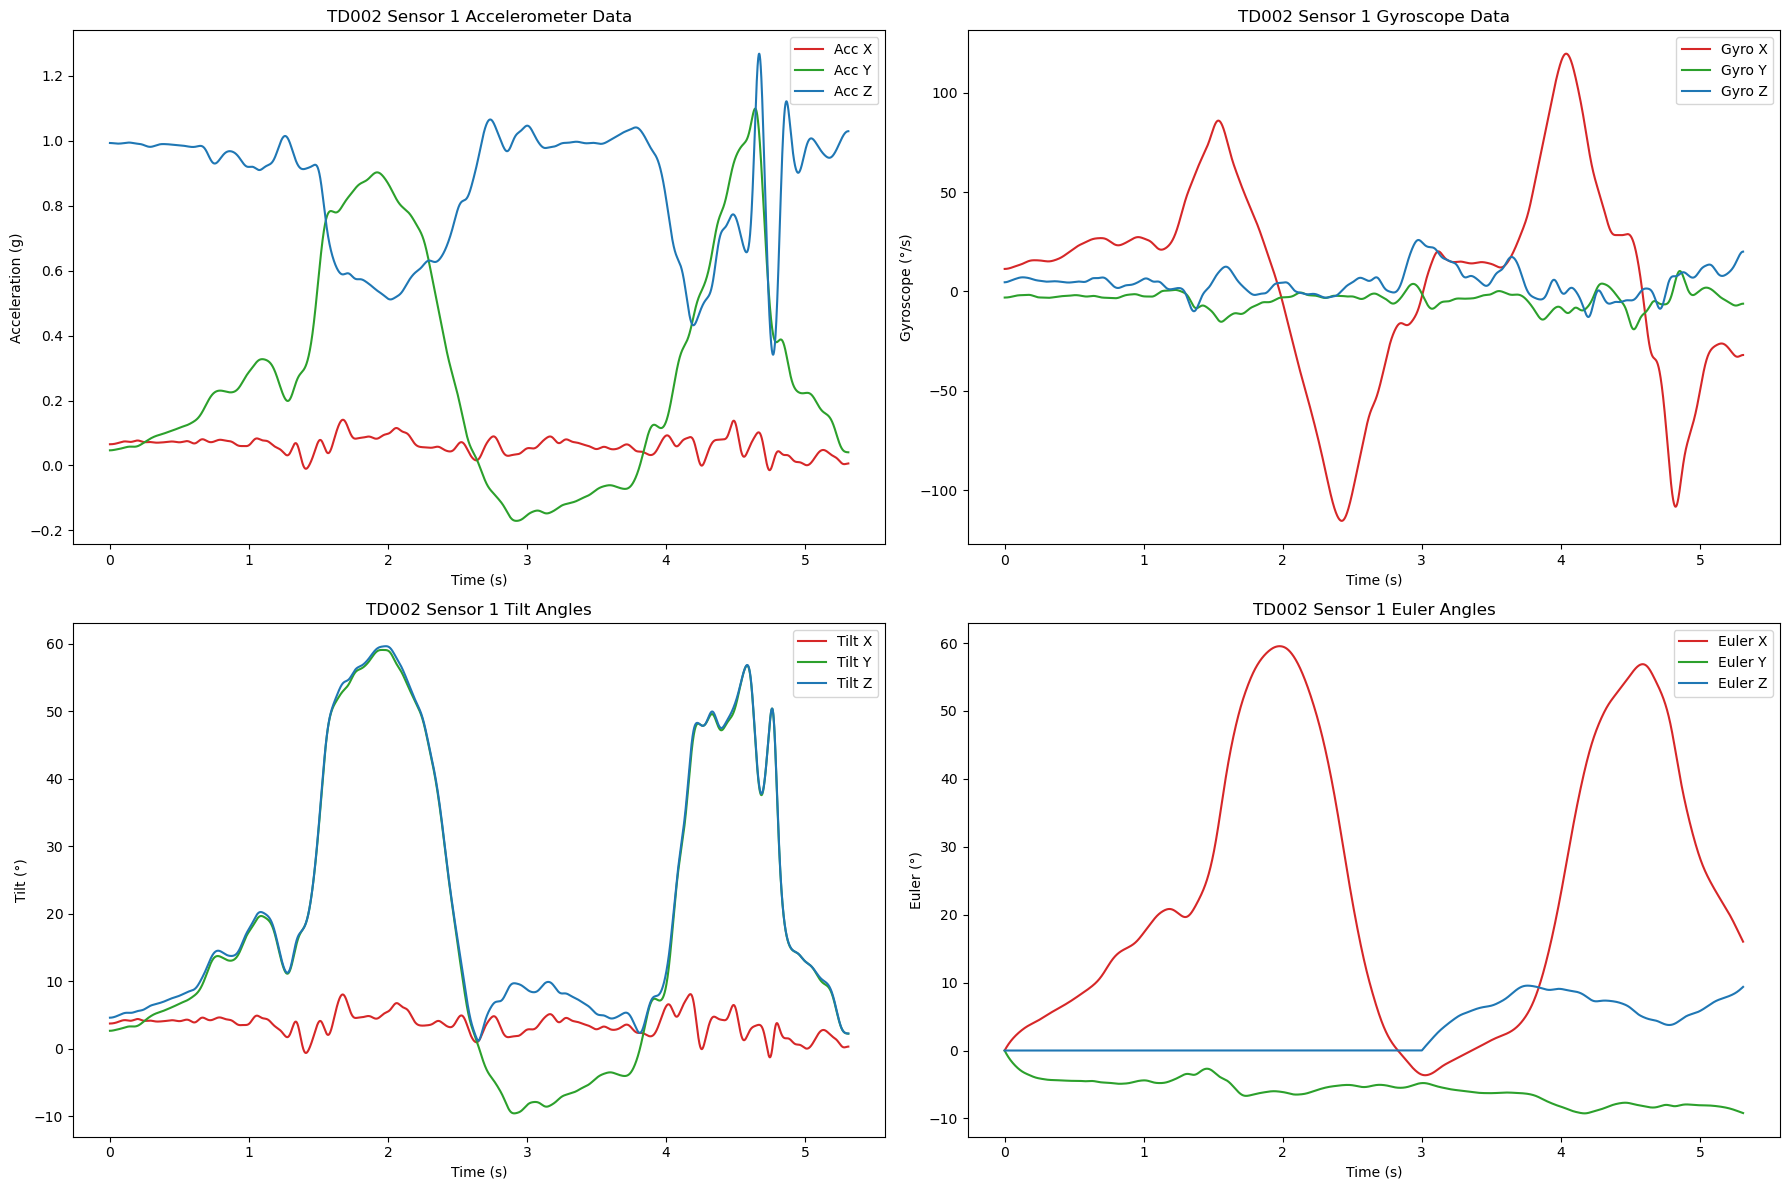

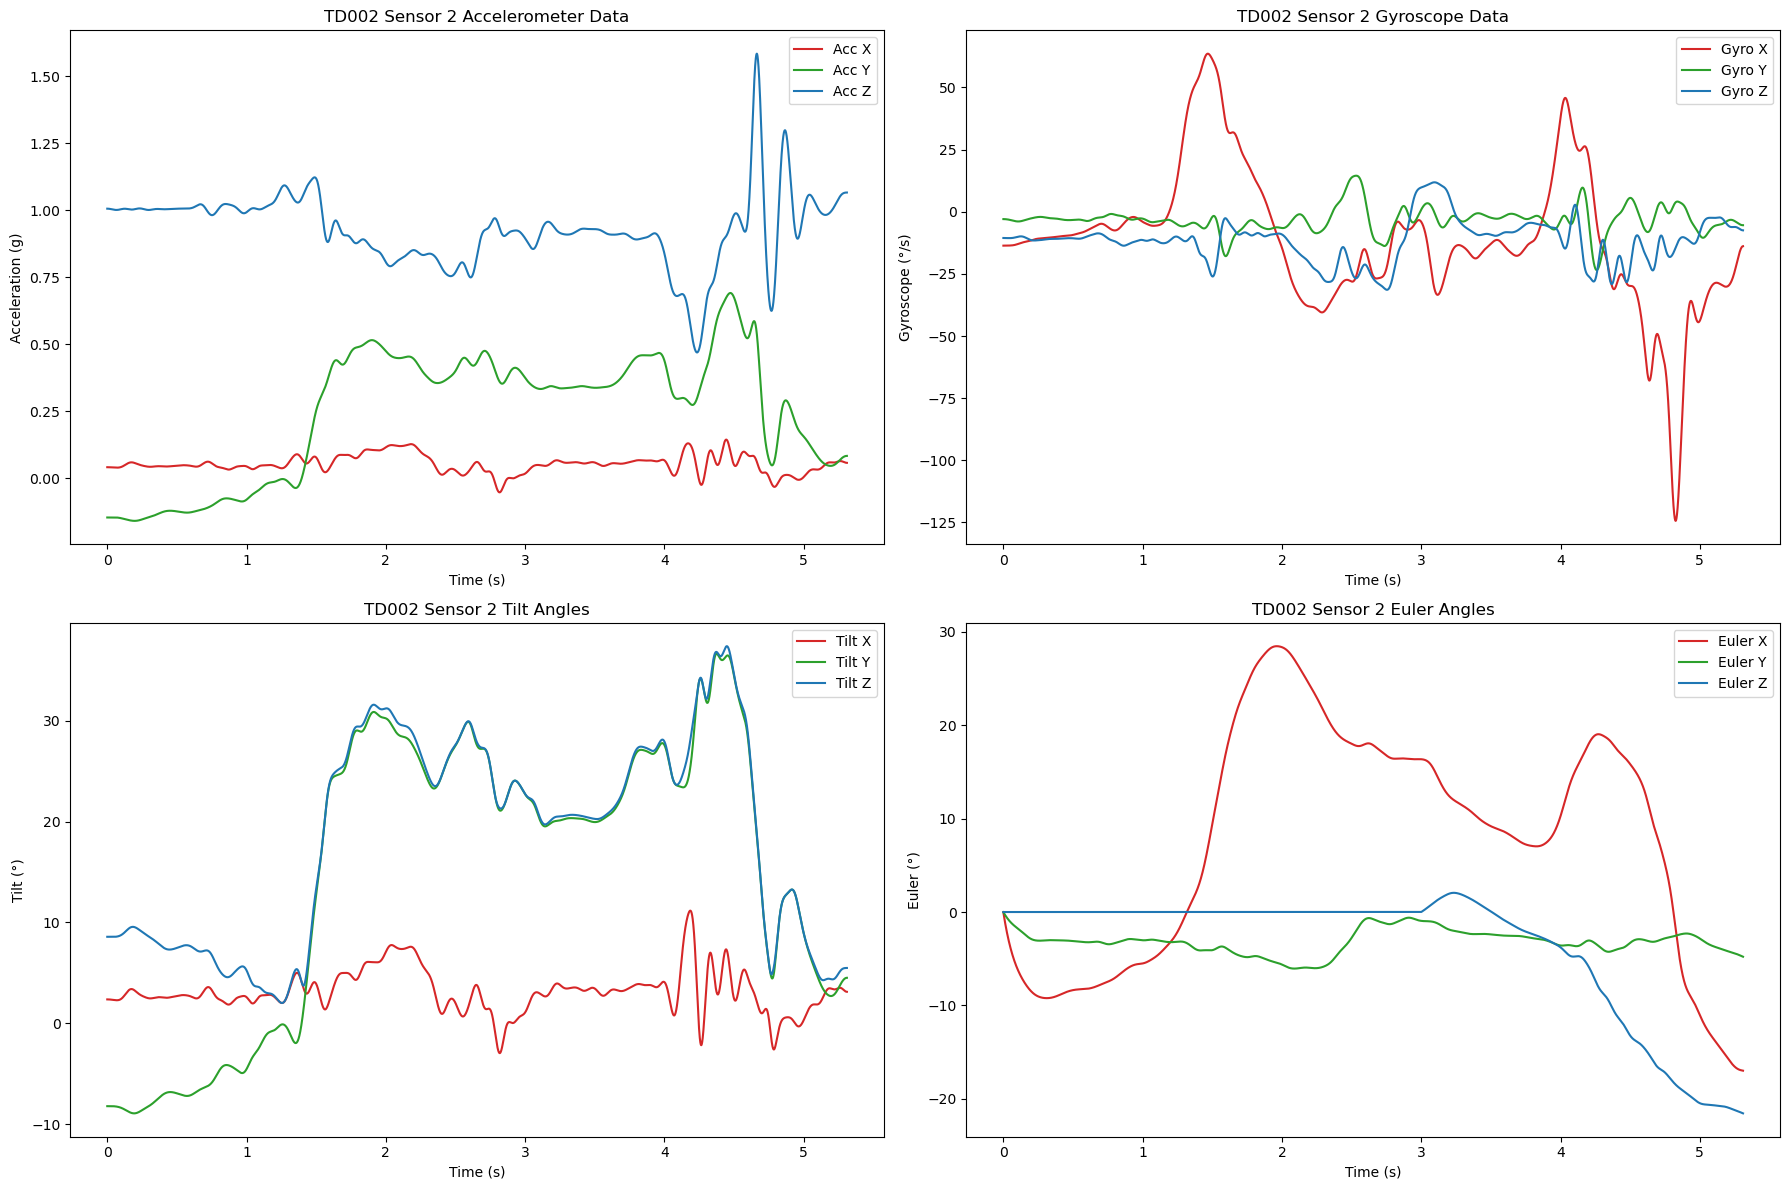

In [7]:
def apply_filter(data, sample_rate, method='butterworth', cutoff=5, order=4, numtaps=255, padlen=128):
    """Apply a specified filter to the data with padding."""
    nyquist = 0.5 * sample_rate
    normal_cutoff = cutoff / nyquist
    
    if method == 'butterworth':
        b, a = butter(order, normal_cutoff, btype='low', analog=False)
        padded_data = np.pad(data, ((padlen, padlen), (0, 0)), mode='reflect')
        filtered_data = filtfilt(b, a, padded_data, axis=0)
        filtered_data = filtered_data[padlen:-padlen, :]
    
    elif method == 'fir':
        fir_coeff = firwin(numtaps, normal_cutoff, window='blackman')
        padded_data = np.pad(data, ((padlen, padlen), (0, 0)), mode='reflect')
        filtered_data = filtfilt(fir_coeff, 1.0, padded_data, axis=0)
        filtered_data = filtered_data[padlen:-padlen, :]
    
    else:
        raise ValueError("Method must be 'butterworth' or 'fir'")
    
    return filtered_data

def process_and_plot_data(analog_data, acc_sensor1, gyro_sensor1, acc_sensor2, gyro_sensor2, analog_frame_rate, title_prefix=''):
    # Define constants
    gravity = 9.81  # Acceleration due to gravity in m/s²
    sample_rate = analog_frame_rate

    # Extract Delsys Sensor 1 - accelerometer and gyroscope data
    accelerometer_nofilt_1 = analog_data[:, acc_sensor1].T.reshape(-1, 3)
    gyroscope_nofilt_1 = analog_data[:, gyro_sensor1].T.reshape(-1, 3)

    # Adjust and convert Sensor 1 data
    accelerometer_nofilt_1 = (accelerometer_nofilt_1 * np.array([1, 1, -1])) / gravity
    gyroscope_nofilt_1 = (gyroscope_nofilt_1 * np.array([1, 1, -1])) * (180 / np.pi)

    # Extract Delsys Sensor 2 - accelerometer and gyroscope data
    accelerometer_nofilt_2 = analog_data[:, acc_sensor2].T.reshape(-1, 3)
    gyroscope_nofilt_2 = analog_data[:, gyro_sensor2].T.reshape(-1, 3)

    # Adjust and convert Sensor 2 data
    accelerometer_nofilt_2 = (accelerometer_nofilt_2 * np.array([1, 1, -1])) / gravity
    gyroscope_nofilt_2 = (gyroscope_nofilt_2 * np.array([1, 1, -1])) * (180 / np.pi)

    # Apply the chosen filter to accelerometer and gyroscope data ('butterworth' or 'fir')
    filter_method = 'fir'
    accelerometer_1 = apply_filter(accelerometer_nofilt_1, sample_rate, method=filter_method)
    gyroscope_1 = apply_filter(gyroscope_nofilt_1, sample_rate, method=filter_method)
    accelerometer_2 = apply_filter(accelerometer_nofilt_2, sample_rate, method=filter_method)
    gyroscope_2 = apply_filter(gyroscope_nofilt_2, sample_rate, method=filter_method)

    # Create a time vector for the x-axis based on the sampling rate
    time = np.linspace(0, len(accelerometer_1) / analog_frame_rate, len(accelerometer_1))

    # Process and plot sensor data
    process_sensor_data((accelerometer_1, gyroscope_1), time, analog_frame_rate, f"{title_prefix} Sensor 1")
    process_sensor_data((accelerometer_2, gyroscope_2), time, analog_frame_rate, f"{title_prefix} Sensor 2")

def process_sensor_data(sensor_data, time, analog_frame_rate, sensor_name):
    """Process accelerometer and gyroscope data to compute orientations and plot results."""
    
    accelerometer, gyroscope = sensor_data
    # Calculate tilt angles in radians
    tilt_x_rad = np.arctan2(accelerometer[:, 0], np.sqrt(accelerometer[:, 1]**2 + accelerometer[:, 2]**2))
    tilt_y_rad = np.arctan2(accelerometer[:, 1], np.sqrt(accelerometer[:,0]**2 + accelerometer[:, 2]**2))
    tilt_z_rad = np.arctan2(np.sqrt(accelerometer[:, 0]**2 + accelerometer[:, 1]**2), accelerometer[:, 2])

    # Convert radians to degrees
    tilt_x_deg = np.degrees(tilt_x_rad)
    tilt_y_deg = np.degrees(tilt_y_rad)
    tilt_z_deg = np.degrees(tilt_z_rad)

    # Initialize the AHRS algorithm
    ahrs = imufusion.Ahrs()
    euler = np.empty((len(time), 3))

    # Initialize array numpy to quaternions
    quaternions = np.empty((len(time), 4))  # Create a four-column array for w, x, y, z

    for index in range(len(time)):
        ahrs.update_no_magnetometer(gyroscope[index], accelerometer[index], (1 / analog_frame_rate))  # Assuming Hz sampling rate
        euler[index] = ahrs.quaternion.to_euler()
        # quaternion in numpy array
        quaternions[index] = [ahrs.quaternion.w, ahrs.quaternion.x, ahrs.quaternion.y, ahrs.quaternion.z]

    # Plotting results
    plot_sensor_data(time, gyroscope, accelerometer, euler, tilt_x_deg, tilt_y_deg, tilt_z_deg, sensor_name)

def plot_sensor_data(time, gyroscope, accelerometer, euler, tilt_x_deg, tilt_y_deg, tilt_z_deg, sensor_name):
    # Create subplots with a smaller figure size
    fig, axs = plt.subplots(2, 2, figsize=(18, 12))

    # Plot accelerometer data
    axs[0, 0].plot(time, accelerometer[:, 0], "tab:red", label="Acc X")
    axs[0, 0].plot(time, accelerometer[:, 1], "tab:green", label="Acc Y")
    axs[0, 0].plot(time, accelerometer[:, 2], "tab:blue", label="Acc Z")
    axs[0, 0].set_title(f'{sensor_name} Accelerometer Data')
    axs[0, 0].set_xlabel('Time (s)')
    axs[0, 0].set_ylabel('Acceleration (g)')
    axs[0, 0].legend()

    # Plot gyroscope data
    axs[0, 1].plot(time, gyroscope[:, 0], "tab:red", label="Gyro X")
    axs[0, 1].plot(time, gyroscope[:, 1], "tab:green", label="Gyro Y")
    axs[0, 1].plot(time, gyroscope[:, 2], "tab:blue", label="Gyro Z")
    axs[0, 1].set_title(f'{sensor_name} Gyroscope Data')
    axs[0, 1].set_xlabel('Time (s)')
    axs[0, 1].set_ylabel('Gyroscope (°/s)')
    axs[0, 1].legend()

    # Plot tilt angles
    axs[1, 0].plot(time, tilt_x_deg, "tab:red", label="Tilt X")
    axs[1, 0].plot(time, tilt_y_deg, "tab:green", label="Tilt Y")
    axs[1, 0].plot(time, tilt_z_deg, "tab:blue", label="Tilt Z")
    axs[1, 0].set_title(f'{sensor_name} Tilt Angles')
    axs[1, 0].set_xlabel('Time (s)')
    axs[1, 0].set_ylabel('Tilt (°)')
    axs[1, 0].legend()

    # Plot Euler angles
    axs[1, 1].plot(time, euler[:, 0], "tab:red", label="Euler X")
    axs[1, 1].plot(time, euler[:, 1], "tab:green", label="Euler Y")
    axs[1, 1].plot(time, euler[:, 2], "tab:blue", label="Euler Z")
    axs[1, 1].set_title(f'{sensor_name} Euler Angles')
    axs[1, 1].set_xlabel('Time (s)')
    axs[1, 1].set_ylabel('Euler (°)')
    axs[1, 1].legend()

    # Adjust layout
    plt.tight_layout()
    plt.show()

# Example usage for PC001
process_and_plot_data(analog_data_pc001, pc001_acc_sensor1, pc001_gyro_sensor1, pc001_acc_sensor2, pc001_gyro_sensor2, analog_frame_rate_pc001, title_prefix='PC001')

# Example usage for PC002
process_and_plot_data(analog_data_pc002, pc002_acc_sensor1, pc002_gyro_sensor1, pc002_acc_sensor2, pc002_gyro_sensor2, analog_frame_rate_pc002, title_prefix='PC002')

# Example usage for TD001
process_and_plot_data(analog_data_td001, td001_acc_sensor1, td001_gyro_sensor1, td001_acc_sensor2, td001_gyro_sensor2, analog_frame_rate_td001, title_prefix='TD001')

# Example usage for TD002
process_and_plot_data(analog_data_td002, td002_acc_sensor1, td002_gyro_sensor1, td002_acc_sensor2, td002_gyro_sensor2, analog_frame_rate_td002, title_prefix='TD002')


In [8]:
def process_sensor_data(sensor_data, time, analog_frame_rate, sensor_name):
    """Process accelerometer and gyroscope data to compute orientations and plot results."""
    
    accelerometer, gyroscope = sensor_data
    # Calculate tilt angles in radians
    tilt_x_rad = np.arctan2(accelerometer[:, 0], np.sqrt(accelerometer[:, 1]**2 + accelerometer[:, 2]**2))
    tilt_y_rad = np.arctan2(accelerometer[:, 1], np.sqrt(accelerometer[:,0]**2 + accelerometer[:, 2]**2))
    tilt_z_rad = np.arctan2(np.sqrt(accelerometer[:, 0]**2 + accelerometer[:, 1]**2), accelerometer[:, 2])

    # Convert radians to degrees
    tilt_x_deg = np.degrees(tilt_x_rad)
    tilt_y_deg = np.degrees(tilt_y_rad)
    tilt_z_deg = np.degrees(tilt_z_rad)

    # Initialize the AHRS algorithm
    ahrs = imufusion.Ahrs()
    euler = np.empty((len(time), 3))

    # Initialize array numpy to quaternions
    quaternions = np.empty((len(time), 4)) # Create a four-column array for w, x, y, z

    for index in range(len(time)):
        ahrs.update_no_magnetometer(gyroscope[index], accelerometer[index], (1/analog_frame_rate))  # Assuming Hz sampling rate
        euler[index] = ahrs.quaternion.to_euler()
        # quaternion in numpy array
        quaternions[index] = [ahrs.quaternion.w, ahrs.quaternion.x, ahrs.quaternion.y, ahrs.quaternion.z]

    # Plotting results
    plot_sensor_data(time, gyroscope, accelerometer, euler, tilt_x_deg, tilt_y_deg, tilt_z_deg, sensor_name)

In [9]:
## Process each sensor data
process_sensor_data((accelerometer_1, gyroscope_1), time, analog_frame_rate, "1 (Trunk)")
process_sensor_data((accelerometer_2, gyroscope_2), time, analog_frame_rate, "2 (Pelvis)")

NameError: name 'accelerometer_1' is not defined